In [13]:
import matplotlib.pyplot as plt
import numpy as np
import opt_einsum
import scipy
from numba import jit
from scipy.interpolate import BSpline

In [14]:
import numpy as np

In [15]:
class BSplineBasis1D:
    def __init__(self, h, p, C):
        self.h = h #Number of basis functions (should equal n_el p + 1, where n_el is the number of elements)
        self.p = p  #Polynomial degree
        self.C = C #Continuity
        self.knot_vector = np.zeros(self.p+1)
        self.knot_vector = np.append(self.knot_vector, np.repeat(np.linspace(0, 1, int((self.h - self.p - 1)/(self.p - self.C)) + 2)[1:-1], self.p - self.C))
        self.knot_vector = np.append(self.knot_vector, np.ones(self.p+1))

    def basis_function(self, n, p, x, knots):
        c = np.zeros(self.h)
        c[n] = 1
        bspline = BSpline(knots, c, p)
        return bspline(x)
    
    def forward(self, x):
        # basis_values = np.zeros((x.shape[0],self.h))
        # for n in range(self.h):
        #     basis_values[:, n] = self.basis_function(n, self.p, x, self.knot_vector)
        basis_values = BSpline.design_matrix(x, self.knot_vector, self.p).toarray()
        return basis_values
    
    def basis_gradient(self, n, p, x, knots):
        c = np.zeros(self.h)
        c[n] = 1
        bspline = BSpline(knots, c, p)
        bspline_derivative = bspline.derivative(1)
        return bspline_derivative(x)
    
    def grad(self, x):
        # basis_gradients = np.zeros((x.shape[0],self.h))
        # for n in range(self.h):
        #     basis_grad = self.basis_gradient(n, self.p, x, self.knot_vector)
        #     basis_gradients[:, n] = basis_grad
        coeffs = np.eye(self.h)
        derivative_basis_functions = [BSpline(self.knot_vector, coeffs[i], self.p).derivative() for i in range(self.h)]
        print(derivative_basis_functions)
        basis_gradients = np.vstack([dbf(x) for dbf in derivative_basis_functions]).T
        return basis_gradients

    def plot_1d_basis(self):
        knots = self.knot_vector
        resolution = 1000
        x_values = np.linspace(knots[self.p], knots[-self.p-1], resolution) # Adjusted range for x_values
        basis_matrix = self.forward(x_values)
        plt.figure(figsize=(8, 6))
        for i in range(self.h):
            plt.plot(x_values, basis_matrix[:,i], label=f'Basis {i}')
        plt.title(f'1D B-spline Basis Functions')
        plt.xlabel('x')
        plt.ylabel('Basis Values')
        plt.xticks(np.array([0,1,2,3,4])/4)
        plt.legend()
        plt.grid(True)
        # plt.savefig("BSpline1D.svg", bbox_inches='tight', transparent=True)
        plt.show()
        
    def plot_1d_basis_gradients(self):
        knots = self.knot_vector
        resolution = 1000
        min_knot = knots[self.p]
        max_knot = knots[-self.p-1]
        x_values = np.linspace(min_knot, max_knot, resolution)  # Use full knot span for x_values
        basis_gradients_matrix = self.grad(x_values)
        plt.figure(figsize=(8, 6))
        for i in range(self.h):
            plt.plot(x_values, basis_gradients_matrix[:, i], label=f'Gradient {i}')
        plt.title(f'Gradients of 1D B-spline Basis Functions')
        plt.xlabel('x')
        plt.ylabel('Gradient Values')
        plt.legend()
        plt.grid(True)
        # plt.savefig("BSplinegrad1D.svg", bbox_inches='tight', transparent=True)
        plt.show()

In [16]:
basis = BSplineBasis1D(h=10, p=3, C=2)

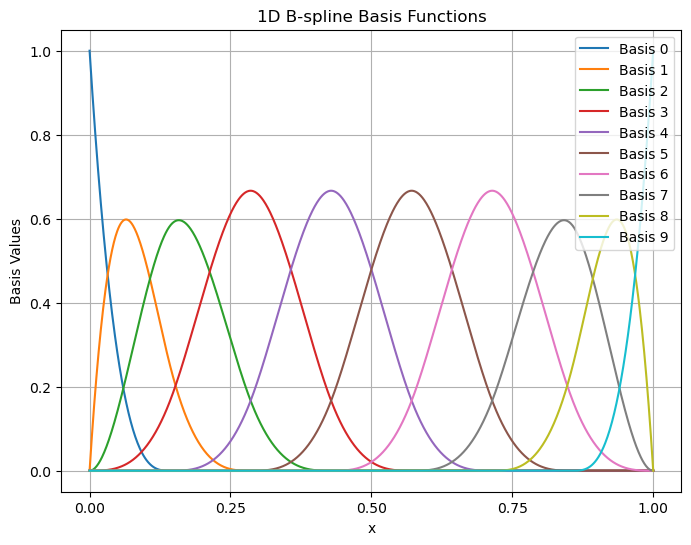

In [17]:
basis.plot_1d_basis()

[<scipy.interpolate._bsplines.BSpline object at 0x7f62993363e0>, <scipy.interpolate._bsplines.BSpline object at 0x7f629c8c3be0>, <scipy.interpolate._bsplines.BSpline object at 0x7f629c8c3b50>, <scipy.interpolate._bsplines.BSpline object at 0x7f62992ee440>, <scipy.interpolate._bsplines.BSpline object at 0x7f62992edcf0>, <scipy.interpolate._bsplines.BSpline object at 0x7f62992eda80>, <scipy.interpolate._bsplines.BSpline object at 0x7f629c8c37f0>, <scipy.interpolate._bsplines.BSpline object at 0x7f629c8c3610>, <scipy.interpolate._bsplines.BSpline object at 0x7f629c8c3df0>, <scipy.interpolate._bsplines.BSpline object at 0x7f62992ee0b0>]


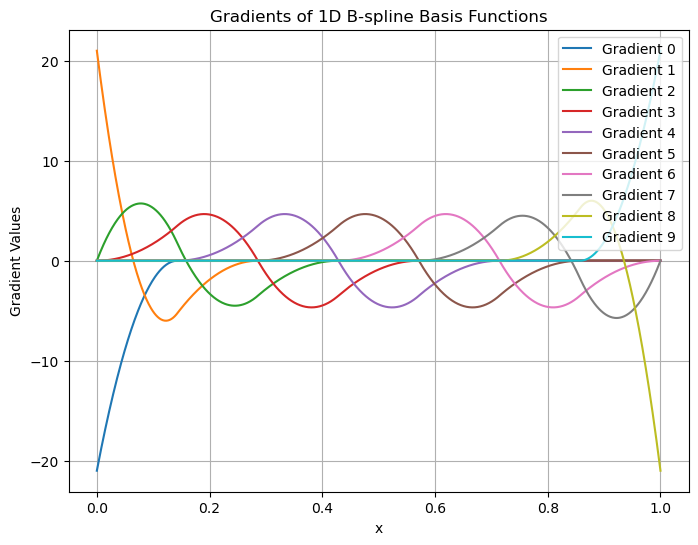

In [18]:
basis.plot_1d_basis_gradients()

In [19]:
k = 3

t = [0., 2., 2., 3., 4.]   # internal knots

a, b = t[0], t[-1]    # base interval is [a, b)

t = [a]*k + t + [b]*k  # add boundary knots

Shape of basis_values: (100, 7)


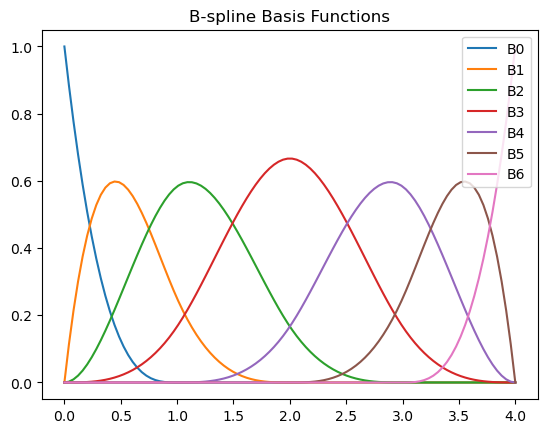

In [20]:
import numpy as np
from scipy.interpolate import BSpline

# Define the B-spline parameters
k = 3  # Degree of the B-spline (cubic)
knots = np.array([0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4])  # Knot vector

# Number of basis functions
num_basis = len(knots) - (k + 1)

# x values where you want to evaluate the basis functions
x = np.linspace(0, 4, 100)

# Vectorized computation of all basis functions
basis_values = BSpline.design_matrix(x, knots, k).toarray()  # Sparse to dense matrix

print("Shape of basis_values:", basis_values.shape)  # (len(x), num_basis)

# Visualize the B-spline basis functions
import matplotlib.pyplot as plt

for i in range(num_basis):
    plt.plot(x, basis_values[:, i], label=f"B{i}")

plt.title("B-spline Basis Functions")
plt.legend()
plt.show()


In [21]:
basis_values.shape

(100, 7)

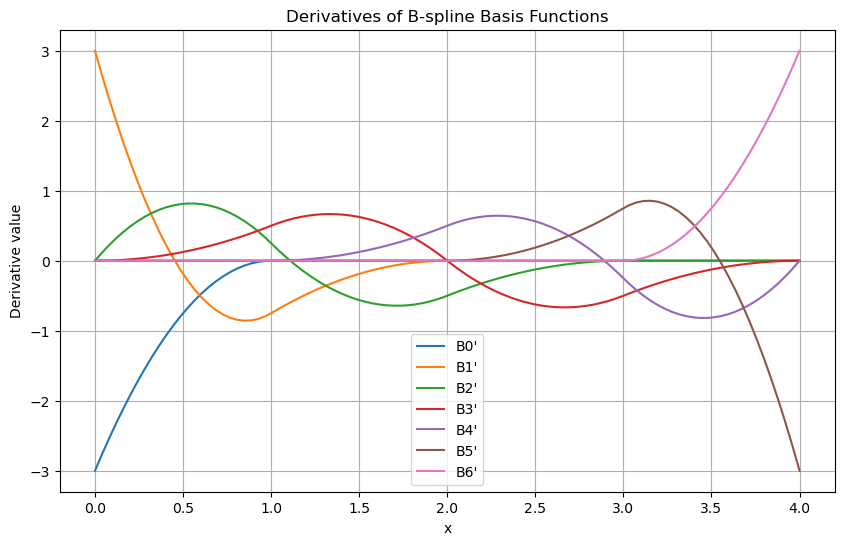

In [22]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

# Define B-spline parameters
k = 3  # Degree of the B-spline (cubic)
knots = np.array([0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4])  # Knot vector
num_basis = len(knots) - (k + 1)  # Number of basis functions

# Coefficient matrix (identity matrix for basis functions)
coeffs = np.eye(num_basis)

# Generate derivative B-spline basis functions
derivative_basis_functions = [BSpline(knots, coeffs[i], k).derivative() for i in range(num_basis)]

# Evaluate derivatives over a range of x values
x = np.linspace(0, 4, 100)
derivative_values = np.array([dbf(x) for dbf in derivative_basis_functions])

# Plot the derivative of B-spline basis functions
plt.figure(figsize=(10, 6))
for i in range(num_basis):
    plt.plot(x, derivative_values[i], label=f"B{i}'")
plt.title("Derivatives of B-spline Basis Functions")
plt.xlabel("x")
plt.ylabel("Derivative value")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Stack all derivative basis functions for vectorized evaluation
derivative_values = np.vstack([dbf(x) for dbf in derivative_basis_functions])
derivative_values.shape


(7, 100)

In [24]:
from joblib import Parallel, delayed

# Define a function to evaluate a derivative basis function
def evaluate_derivative(dbf, x):
    return dbf(x)

# Parallel evaluation of all derivative basis functions
derivative_values = Parallel(n_jobs=-1)(
    delayed(evaluate_derivative)(dbf, x) for dbf in derivative_basis_functions
)


In [25]:
# Parallel evaluation of all derivative basis functions
derivative_values = Parallel(n_jobs=-1)(
    delayed(evaluate_derivative)(dbf, x) for dbf in derivative_basis_functions
)

In [29]:
np.array(derivative_values).shape

(7, 100)